In [1]:
import gym
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from random import sample

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
import pickle

import pandas as pd
from openpyxl import load_workbook

print(tf.__version__)
print(device_lib.list_local_devices())

c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\Users\Go\minic

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12600413571047762901
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 711671808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12243291502669015205
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            # x = keras.layers.Dense(n_percep, activation= act_function)(inputs)
            x = keras.layers.Dense(n_percep,)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,)(x)
            # x = keras.layers.Dense(n_percep)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

def get_batchdata(replay_buffer, n_batch):
    batched_dataset = np.array(sample(replay_buffer, n_batch))

    s_batch = tf.reshape(batched_dataset[:,0].tolist(),[-1,4])
    a_batch = tf.reshape(batched_dataset[:,1].astype(np.int32),[-1,1])
    ns_batch = tf.reshape(batched_dataset[:,2].tolist(),[-1,4])
    r_batch = tf.reshape(batched_dataset[:,3].astype(np.float32),[-1,1])
    done_batch = tf.reshape(batched_dataset[:,4].astype(np.float32),[-1,1])

    return s_batch,a_batch,ns_batch,r_batch,done_batch

def play_random_action_episodes(environment, replay_buffer, n_random_episode):
    for _ in range(n_random_episode):
        s = environment.reset()
        a = environment.action_space.sample()
        while True:
            ns, r, done, _ = environment.step(a)
            done = 1 if done else 0
            replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))

            if done == 1:
                s = environment.reset()
                a = environment.action_space.sample()
                break
            else:
                s = ns
                a = environment.action_space.sample()

In [3]:
def get_action(actor,state, num_samples: int = 1):
    logit_sam = actor(state)
    m = tfp.distributions.Categorical(logits = logit_sam)
    return tf.reshape(m.sample(num_samples),[-1,num_samples])

def get_mean_qsa(qs,sampled_as):
    q_list = []
    for i in range(len(sampled_as[0,:])):
        q = tf.gather_nd(params = qs,indices=tf.reshape(sampled_as[:,i],[-1,1]), batch_dims=1,)
        q_list.append(q)
    mean_q = tf.reshape(tf.math.reduce_mean(q_list,axis=0,),[-1,1])
    return mean_q

In [7]:
# @tf.function()
def train_critic_step(actor_network,q_network,q_target_network,optimizer, loss_function,tau,s,a,ns,r,done,gamma):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    qs = q_target_network(ns)
    sampled_as = get_action(actor_network,ns,num_samples=5)
    mean_qsa = get_mean_qsa(qs,sampled_as)
    q_target = r + gamma * mean_qsa * (1 - done)
    # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
    q_val = tf.reshape(tf.gather_nd(q_network(s),a,batch_dims=1,),[-1,1])
    loss = loss_function(q_val, q_target)
  grads = tape.gradient(loss, q_network.trainable_variables)
  optimizer.apply_gradients(zip(grads, q_network.trainable_variables))
  # # # target net soft update
  # soft_g = [(b-a)*tau for a,b in zip(q_target_network.trainable_variables, q_network.trainable_variables)]
  # # # # soft_g = (np.array(critic_qnet.trainable_variables) - np.array(q_target_network.trainable_variables))*tau
  # optimizer.apply_gradients(zip(soft_g, q_target_network.trainable_variables))
  return loss

# @tf.function()
def train_actor_step(actor_network,q_target_network,s,a,lamb,optimizer):
  with tf.GradientTape() as tape:
      
      # log_probability 계산
      logits = actor_network(s)
      m = tfp.distributions.Categorical(logits = logits)
      log_prob = tf.reshape(m.log_prob(tf.squeeze(a)),[-1,1])
      
      #가중치항 계산
      qs = q_target_network(s)
      action_probs = tf.nn.softmax(logits, axis=None, name=None)
      vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
      qas = tf.reshape(tf.gather_nd(qs,a,batch_dims=1,),[-1,1])
      adv = qas - vs
      weight_term = tf.math.exp((1/lamb*adv), name=None)
      
      #loss
      loss = tf.math.reduce_mean(log_prob * weight_term*-1)
      # loss = tf.math.reduce_mean(qas*log_prob)
      # loss = tf.math.reduce_mean(log_prob * weight_term)*-1
      
  actor_grad = tape.gradient(loss, actor_network.trainable_variables)
  optimizer.apply_gradients(zip(actor_grad, actor_network.trainable_variables))
  # train_accuracy.update_state(labels, predictions)
  
  return loss

In [273]:
GAMMA = 0.95
LAM = 0.3
BATCH_SIZE = 256
BUFFER_SIZE = 500000
DQN_LEARNING_RATE = 0.0001
TAU = 0.001
MAX_EPISODE_NUM = 300

random_epi_num = 5000

env = gym.make('CartPole-v1')
hidden_structure= [64, 128,256,128,64]
input_shape= 4
output_shape= 2
act_function= 'relu'
optimizer = keras.optimizers.Adam(learning_rate=DQN_LEARNING_RATE)
loss_fun = tf.keras.losses.MeanSquaredError()

actor = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
q_net = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
q_net_tar = make_dense_model(hidden_structure,input_shape,act_function,output_shape)

replay_buffer = []

In [ ]:
# play_random_action_episodes(env, replay_buffer, random_epi_num)

# for i in range(MAX_EPISODE_NUM):
actor_loss_list = []
critic_loss_list = []
cur_list = []
best_reward = 1
for i in range(MAX_EPISODE_NUM):
    s = env.reset()
    env.render()
    a = get_action(actor,tf.convert_to_tensor([s]),)
    cur = 0
    while True:
        ns, r, done, _ = env.step(a.numpy()[0,0])
        env.render()
        cur += r
        done = 1 if done else 0

        if len(replay_buffer) < BUFFER_SIZE:
            replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
        else:
            replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
            replay_buffer = replay_buffer[1:]

        if done == 1:
            s = env.reset()
            env.render()
            a = get_action(actor,tf.convert_to_tensor([s]),)
            cur_list.append(cur)

            break
        else:
            s = ns
            a = get_action(actor,tf.convert_to_tensor([s]),)

    if len(replay_buffer)>BATCH_SIZE:
        state, action, nstate, reward, done = get_batchdata(replay_buffer,BATCH_SIZE)
        c_loss = train_critic_step(actor,q_net,q_net_tar,optimizer, loss_fun,TAU,state, action, nstate, reward, done, GAMMA)
        a_loss = train_actor_step(actor,q_net_tar,state,action,LAM)
        # 타겟넷 업데이트
        phi = q_net.get_weights()
        target_phi = q_net_tar.get_weights()
        for j in range(len(phi)):
            target_phi[j] = TAU * phi[j] + (1 - TAU) * target_phi[j]
        q_net_tar.set_weights(target_phi)


        critic_loss_list.append(c_loss)
        actor_loss_list.append(a_loss)
        print(f"iter: {i}, closs: {c_loss}, aloss: {a_loss}, reward: {cur_list[-1]}" )



# state, action, nstate, reward, done = get_batchdata(replay_buffer,BATCH_SIZE)
# train_critic_step(q_net,q_net_tar,optimizer, loss_fun,TAU,state, action, nstate, reward, done)
# train_actor_step(actor,q_net_tar,state,action,)

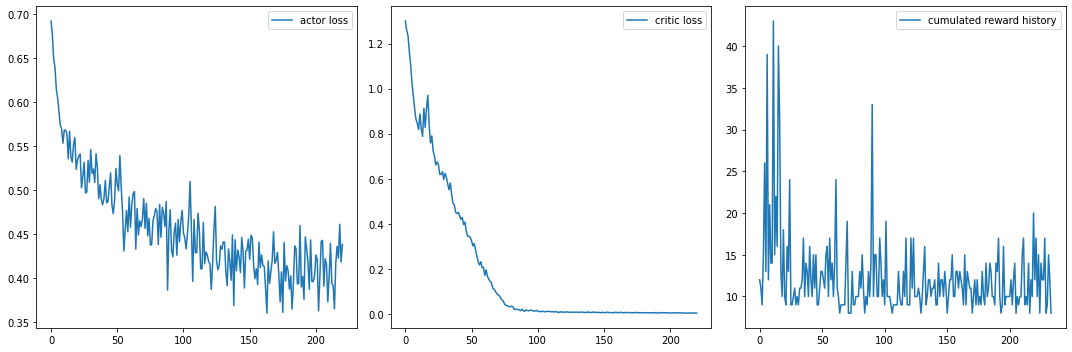

In [269]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_loss_list, label='actor loss')
axes[0].legend()
axes[1].plot(critic_loss_list, label='critic loss')
axes[1].legend()
axes[2].plot(cur_list, label='cumulated reward history')
axes[2].legend()
# axes[2].hist(cur_list, density=True, label='only_online_awac')
# axes[2].legend()
fig.tight_layout()

* 파라미터 서치

In [11]:
space = [hp.uniform('gamma',0.8,0.999),            
         hp.uniform('lam',0.1,0.9),          
         hp.uniform('lr_rate',0.0001,0.01),                
         hp.uniform('tau',0.0001,0.01), 
         ]

def search_params(args):
    gamma,lam,lr_rate,tau = args

    env = gym.make('CartPole-v1')
    hidden_structure= [64, 128,256,128,64]
    input_shape= 4
    output_shape= 2
    act_function= 'relu'

    loss_fun = tf.keras.losses.MeanSquaredError()

    actor = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
    q_net = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
    q_net_tar = make_dense_model(hidden_structure,input_shape,act_function,output_shape)

    replay_buffer = []



    GAMMA = gamma
    LAM = lam
    BATCH_SIZE = 256
    BUFFER_SIZE = 500000
    DQN_LEARNING_RATE = lr_rate
    optimizer = keras.optimizers.Adam(learning_rate=DQN_LEARNING_RATE)
    TAU = tau
    MAX_EPISODE_NUM = 200
    cur_hist_list = []
    for _ in range(10):
        cur_hist = []
        for i in range(MAX_EPISODE_NUM):
            s = env.reset()
            
            a = get_action(actor,tf.convert_to_tensor([s]),)
            cur = 0
            while True:
                ns, r, done, _ = env.step(a.numpy()[0,0])
                
                cur += r
                done = 1 if done else 0

                if len(replay_buffer) < BUFFER_SIZE:
                    replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
                else:
                    replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
                    replay_buffer = replay_buffer[1:]

                if done == 1:
                    s = env.reset()
                    
                    a = get_action(actor,tf.convert_to_tensor([s]),)
                    cur_hist.append(cur)
                    
                    break
                else:
                    s = ns
                    a = get_action(actor,tf.convert_to_tensor([s]),)

            if len(replay_buffer)>BATCH_SIZE:
                state, action, nstate, reward, done = get_batchdata(replay_buffer,BATCH_SIZE)
                c_loss = train_critic_step(actor,q_net,q_net_tar,optimizer, loss_fun,TAU,state, action, nstate, reward, done,GAMMA)
                a_loss = train_actor_step(actor,q_net_tar,state,action,LAM,optimizer)
                # 타겟넷 업데이트
                
                phi = q_net.get_weights()
                target_phi = q_net_tar.get_weights()
                for j in range(len(phi)):
                    target_phi[j] = TAU * phi[j] + (1 - TAU) * target_phi[j]
                q_net_tar.set_weights(target_phi)
        cur_hist_list.append(cur_hist)
    result = np.array(cur_hist_list).mean()
    return -1*result


trials=Trials()
# trials = pickle.load(open('result.p', "rb"))    #trials불러오기
eval_it = 100
best = fmin(search_params,space,algo=tpe.suggest,max_evals=eval_it,trials=trials)
pickle.dump(trials, open("result_awac_cartpole.p", "wb"))     
print(best)
print(space_eval(space, best))  






  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\Go\AppData\Local\Temp\ipykernel_12728\4255117621.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.




In [ ]:
# trials = pickle.load(open('result.p', "rb"))
tresults = pd.DataFrame({'iteration':trials.idxs_vals[0]['gamma'],
                              'gamma':trials.idxs_vals[1]['gamma'],'lam':trials.idxs_vals[1]['lam'],'lr_rate':trials.idxs_vals[1]['lr_rate'],'tau':trials.idxs_vals[1]['tau'],
                              'mean_reward':[x['loss'] for x in trials.results]})
#tresults["t_result"] = t_results

#엑셀에 저장
#writer = pd.ExcelWriter(path+site+'optimization_results/'+resultfilename)#,engine=xlsxwriter)
book = load_workbook('search_hist.xlsx')
writer = pd.ExcelWriter('search_hist.xlsx',engine='openpyxl')
writer.book = book
#
tresults.to_excel(writer, sheet_name = 'search_hist_awac_cartpole')
writer.save()
writer.close()
      

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

data = pd.read_excel("search_hist.xlsx", sheet_name = 'search_hist_awac_cartpole')
data.loc[:,'mean_reward'] = -1*data.loc[:,'mean_reward']
data
fig = px.parallel_coordinates(data, color="mean_reward", dimensions=data.columns,
                              color_continuous_scale=px.colors.sequential.Blues,
                              title="Optimization result",
                            #   range_color=[0,0.3]
                          
                              )

fig.write_html('search_hist_pall_awac.html')